In [1]:
import os
from math import *
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import rioxarray as rxr
import geopandas as gpd
import rasterstats as rs
import earthpy as et

sns.set_style("white")
sns.set(font_scale=1.5)

os.chdir(os.path.join(et.io.HOME,'earth-analytics','data'))

In [2]:
lidar_path = os.path.join("spatial-vector-lidar",
                          "california",
                          "neon-sjer-site",
                          "2013",
                          "lidar",
                          "SJER_lidarCHM.tif")

sjer_chm_data = rxr.open_rasterio(lidar_path, masked=True).squeeze()

plot_buffer_path = os.path.join("spatial-vector-lidar",
                                "outputs",
                                "plot_buffer.shp")

sjer_tree_heights = rs.zonal_stats(plot_buffer_path,
                                   sjer_chm_data.values,
                                   affine=sjer_chm_data.rio.transform(),
                                   geojson_out=True,
                                   copy_properties=True,
                                   nodata=0,
                                   stats="mean max")

sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_tree_heights)

path_insitu = os.path.join("spatial-vector-lidar",
                           "california",
                           "neon-sjer-site",
                           "2013",
                           "insitu",
                           "veg_structure",
                           "D17_2013_SJER_vegStr.csv")

sjer_insitu = pd.read_csv(path_insitu)

insitu_stem_ht = sjer_insitu.groupby('plotid', as_index=False)

insitu_stem_ht = insitu_stem_ht['stemheight'].agg(['max', 'mean'])
insitu_stem_ht = insitu_stem_ht.rename(
    columns={'max': 'insitu_maxht', 'mean': 'insitu_meanht'})

insitu_stem_ht.reset_index(inplace=True)

sjer_lidar_height_df = sjer_lidar_height_df.rename(
    columns={'max': 'lidar_max',
             'mean': 'lidar_mean',
             'min': 'lidar_min'})

sjer_final_height = sjer_lidar_height_df.merge(insitu_stem_ht,
                                               left_on='Plot_ID',
                                               right_on='plotid')

sjer_final_height_df = pd.DataFrame(sjer_final_height)

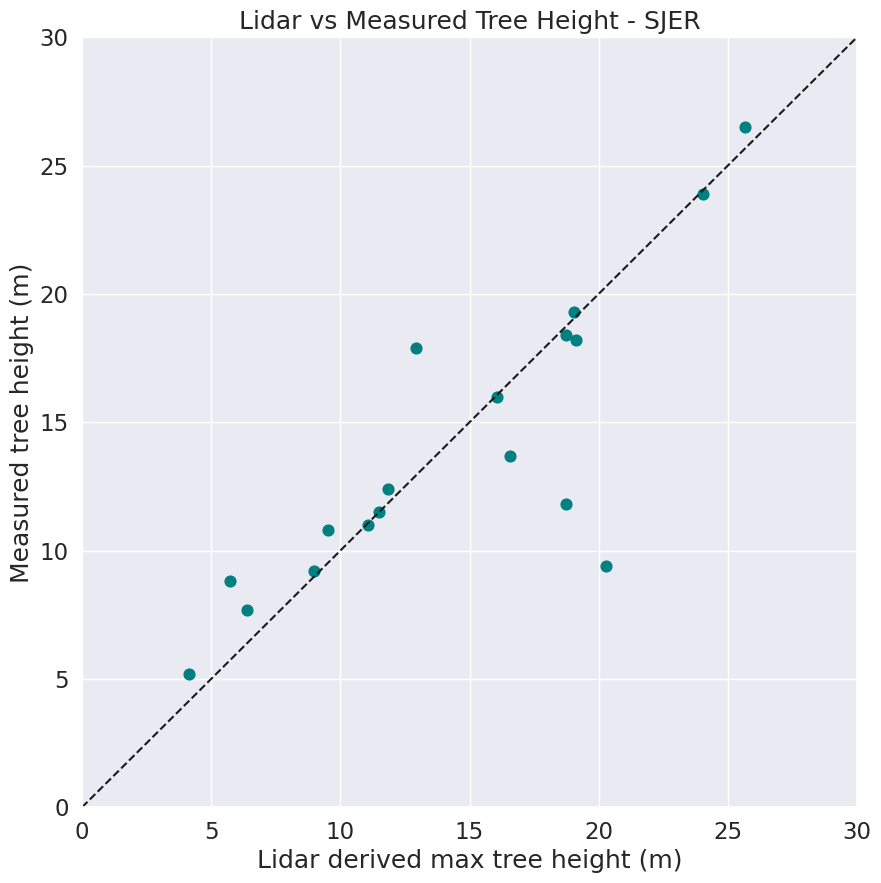

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))

sjer_final_height_df.plot('lidar_max', 'insitu_maxht',
                          kind='scatter', color="teal",
                          s=60, ax=ax)

ax.set(xlim=[0, 30], ylim=[0, 30], label="Data")
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',
        c='k', label="1:1 line")

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)", title="Lidar vs Measured Tree Height - SJER")

plt.show()

In [4]:
x = sjer_final_height_df.lidar_max
y = sjer_final_height_df.insitu_maxht

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2)

slope: 0.7607314439776315 
intercept: 2.98146647443445 
r squared: 0.6910551716430489


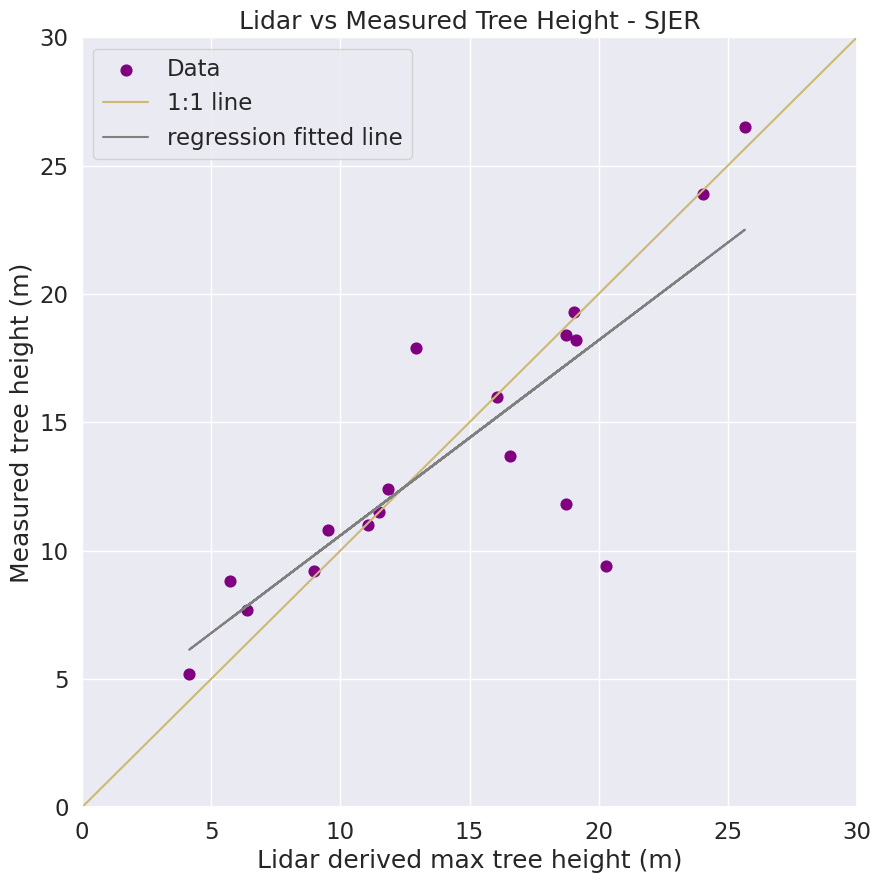

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))

m = slope.astype(float)

sjer_final_height_df.plot('lidar_max',
                          'insitu_maxht',
                          kind='scatter',
                          color="purple",
                          s=60,
                          ax=ax,
                          label="Data")

ax.set(xlim=[0, 30], ylim=[0, 30])
ax.plot((0, 1), (0, 1), 'y-', transform=ax.transAxes, label="1:1 line")
ax.plot(x, m*x + intercept, 'grey', label='regression fitted line')

ax.set(xlabel="Lidar derived max tree height (m)",
       ylabel="Measured tree height (m)",
       title="Lidar vs Measured Tree Height - SJER")

plt.legend()

plt.show()


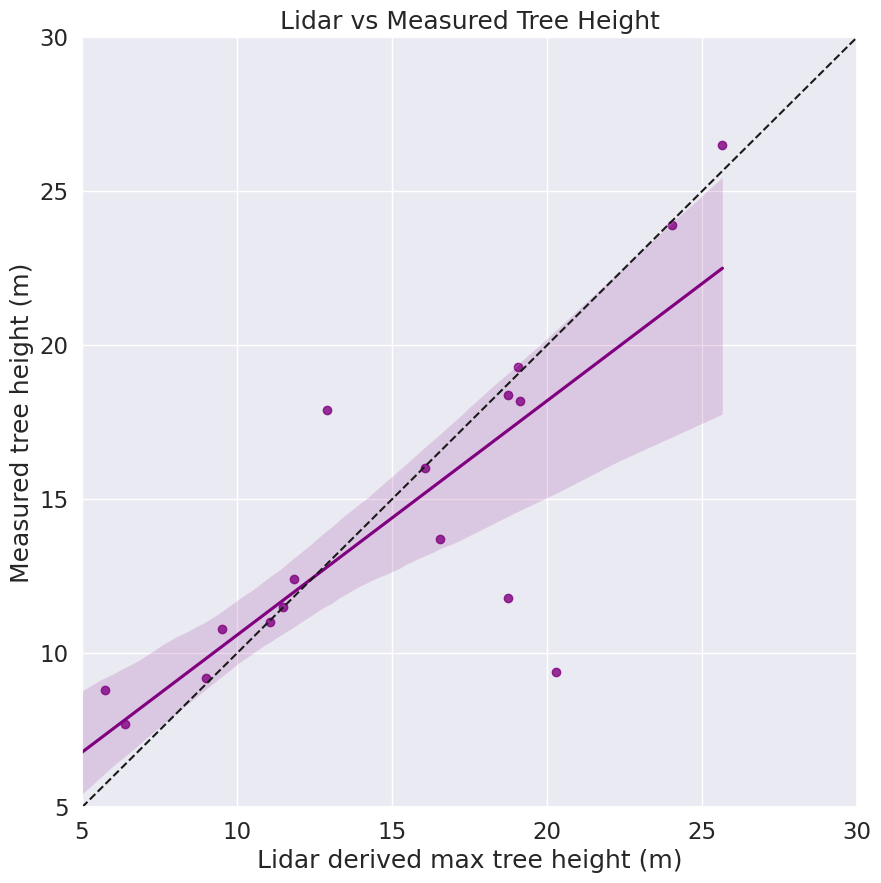

<bound method Axes.set of <Axes: title={'center': 'Lidar vs Measured Tree Height'}, xlabel='Lidar derived max tree height (m)', ylabel='Measured tree height (m)'>>

In [8]:
fig, ax = plt.subplots(figsize=(10,10))

ax = sns.regplot(x="lidar_max", y="insitu_maxht", data=sjer_final_height_df, color="purple")

ax.set(xlim=[5,30], ylim=[5,30])

ax.plot((0,1), (0,1), transform=ax.transAxes, ls="--", c="k")

ax.set(xlabel="Lidar derived max tree height (m)", ylabel="Measured tree height (m)", title="Lidar vs Measured Tree Height")

plt.show()

ax.set